In [4]:
from custom_tf_idf_transformer_class import CustomClassTfidfTransformer

import numpy as np
import pandas as pd
from annoy import AnnoyIndex
from cdiscount import config, snowflake
from cdiscount.config import load_secrets
from snowflake.connector import SnowflakeConnection
from tqdm import tqdm
import nltk
from collections import Counter
from unidecode import unidecode
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
from community import community_louvain
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
def cleaning_strings(strings: pd.Series):
    return (
        strings.str.lower()
        .str.replace(
            r'(\d+)[\.,\s]0', r'\1', regex=True
        )  # Remove ".0" ",0" and " 0" at the end of float numbers. Ex: 2.0 => 2
        .str.replace(r'(\d+)[,.](\d+)', r'\1\2', regex=True)
        .str.replace(
            r'(^|\s)(\d+)(\s)([A-Za-z0-9À-ÿ])', r'\1\2\4', regex=True
        )  # Remove white space between digits and following string. Ex: 5 ah => 5ah. Bad ex: ps 5 noir => ps 5noir
        .str.replace(
            '[^A-Za-z0-9À-ÿ.,]', ' ', regex=True
        )  # Remove special characters and keep accents. Accents are usefull for BERT embeddings but cause bad string normalization. Ex canapé and canape will be different strings
        .str.replace('\s+', ' ', regex=True)  # Remove consecutive whitespaces
        .str.replace(r'(\d+)\sx\s(\d+)', r'\1x\2', regex=True)
        # Remove white space after words "avec", "sans" and "pour". Ex: avec batterie => avec_batterie
        .str.replace('avec ', 'avec_', regex=False)
        .str.replace('sans ', 'sans_', regex=False)
        .str.replace('pour ', 'pour_', regex=False)
        .apply(unidecode)  # Remove accents
        .str.strip()
    )

GET EMBEDDINGS AND PRODUCTS_DF

In [6]:
secrets_file = "/home/jupyter/icarusight/doubloons_detection/secrets.yml"
SNOW_SECRETS = load_secrets(filename=secrets_file, key="snowflake")
AZURE_SECRETS = load_secrets(filename=secrets_file, key="azure_openai_embeddings")

In [7]:
secrets = config.load_secrets(secrets_file, key="snowflake")
embedding_query = "queries/get_embeddings.sql"
product_query = "queries/get_product_canape.sql"


with snowflake.get_snowflake_connection(**secrets) as con:
    products_df = snowflake.query_snowflake_to_df(product_query, con=con)
    embeddings_df = snowflake.query_snowflake_to_df(embedding_query, con=con)
print("first bottleneck passed (querying bottleneck)")
embeddings_df["embedding"] = embeddings_df.embedding.apply(eval)
print("second bottleneck passed (evaluating bottleneck)")

first bottleneck passed (querying bottleneck)
second bottleneck passed (evaluating bottleneck)


ANNOY(ING) NEIGHBORS

In [8]:
def id2product_id(index):
    return embeddings_df.product_id.iloc[index]

def get_neighbors(u, i, k):
    neighbors, distances = u.get_nns_by_item(i=i, n=k + 1, include_distances=True)
    return pd.DataFrame(
        {
            "id": i,
            "rank": [j for j in range(1, k + 1)], #Removing the item itself
            "neighbor_id": neighbors[1 : k + 1],
            "distance": distances[1 : k + 1],
        }
    )

In [76]:
build_tree = False # When set to True, this creates the canape_embeddings.ann file 
min_max_normalization = True
saving_csv = True

if build_tree:
    t = AnnoyIndex(AZURE_SECRETS["expected_embedding_size"], "dot")
    for i, v in enumerate(embeddings_df.embedding):
        t.add_item(i, v)
    t.build(n_trees=100, n_jobs=-1)
    vdb_file = "canape_embeddings.ann"
    t.save(vdb_file)


u = AnnoyIndex(AZURE_SECRETS['expected_embedding_size'], 'dot')
u.load(vdb_file)
all_neighbors = []
for i in tqdm(range(0, u.get_n_items())):
    all_neighbors.append(get_neighbors(u=u, i=i, k=10))
all_neighbors = pd.concat(all_neighbors)
all_neighbors['id'] = all_neighbors['id'].apply(id2product_id)
all_neighbors['neighbor_id'] = all_neighbors['neighbor_id'].apply(id2product_id)
if min_max_normalization:
    scaler = MinMaxScaler()
    all_neighbors['distance'] = scaler.fit_transform(all_neighbors[['distance']])

100%|██████████| 39200/39200 [00:47<00:00, 826.59it/s]


GRAPH CREATION AND COMMUNITY DETECTION

In [22]:
g = nx.Graph()
print("Nodes added, adding edges...")
num_edges = len(all_neighbors)
# Nodes are added when an id in the add_edge isn't found.
for i in tqdm(range(num_edges), total=num_edges):
    g.add_edge(all_neighbors['id'].iloc[i], all_neighbors['neighbor_id'].iloc[i], weight=all_neighbors['distance'].iloc[i])
print("Edges added.")
partitions = community_louvain.best_partition(g)

Nodes added, adding edges...


100%|██████████| 392000/392000 [00:09<00:00, 39696.17it/s]


Edges added.


In [27]:
products_df.set_index('product_id', inplace=True)
products_df['community_id'] = partitions
products_df.reset_index(inplace=True)
products_df.dropna(inplace=True)

In [31]:
products_df

,product_id,product_name,product_long_description,brand_name,product_category_name,community_id
2,SAL7861358966867,Cadre de canapé-lit extensible - SALALIS - mét...,🎈Couleur : noir🎈Matériau : métal enduit de pou...,SALALIS,CANAPE - SOFA - DIVAN,115.0
6,DEL4250809390598,Canapé Clovis anthracite look antique ottoman ...,Modules extensibles - Microvelours facile à ...,DELIFE,CANAPE - SOFA - DIVAN,35.0
9,EST7703675348240,SWT Canapé à 2 places Cuir synthétique Blanc ...,// Couleur : blanc// Matériau : Rembourrage en...,ESTINK,CANAPE - SOFA - DIVAN,14.0
11,BEL4260624112206,Beliani - Canapé 3 places en tissu gris clair ...,Ce canapé fournit un espace necessaire pour s...,BELIANI,CANAPE - SOFA - DIVAN,38.0
16,MEN8683342560313,Ensemble Fauteuil et canapé 3 places convertib...,Confortable et fonctionnel ! Notre ensemble fa...,MENZZO,ENSEMBLE CANAPES,2.0
...,...,...,...,...,...,...
102859,VGE1688614505427,NEUF Canapé d'angle sectionnel avec coussins B...,"Couleur du coussin : rouge Matériau : pin, imp...",VGEBY,CANAPE - SOFA - DIVAN,18.0
102862,INS3700732979465,Canapé d'angle SUN convertible EXPRESS 120cm m...,ACCOUDOIRS ÉTROITS POUR UN GAIN DE PLACE OPTIM...,ITALIAN SPIRIT,CANAPE - SOFA - DIVAN,91.0
102863,FOL0699905053879,"Housse de Canapé Élastique en Forme de L, Revê...",2 places : 145-185 cm ; 4 places : 235-300 cm...,FOLAYA,HOUSSE DE CANAPE,12.0
102867,HON6260250574957,90*140cm Housse de Canapé Clic clac avec Mouss...,Veuillez consulter le guide de mesure et mesur...,GUOCU,HOUSSE DE CANAPE,25.0


COMMUNITY ANALYSIS

In [28]:
#from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer

def extract_vocabulary(documents, stop_words, min_len: int = 3, min_df: int = 2):
    vocabulary = ' '.join(documents)
    vocabulary = [w for w in vocabulary.split() if w not in stop_words]
    vocabulary = Counter(vocabulary)
    for k, v in vocabulary.most_common():
        if v < min_df or len(k) < min_len:
            del vocabulary[k]
    return [k for k, _ in vocabulary.most_common()]

def merge_columns(row):
    return f"{' '.join(row['product_name_list'])} {row['description']}"

def get_top_words(response, threshold, feature_array):
    #response_normalized = normalize(response, axis=1, norm='l2')
    response_normalized = custom_norm(response.toarray())
    response_normalized = response_normalized.reshape(-1)
    sorted_nzs = np.argsort(response_normalized.data)[::-1]
    feature_array = feature_array[sorted_nzs]
    response_normalized = response_normalized[sorted_nzs]
    response_normalized = response_normalized > threshold
    res = feature_array[response_normalized]
    return np.apply_along_axis(' | '.join, 0, res)

def custom_norm(x):
    norm = x.sum(axis=1)
    return x / norm

# TF-IDF METHOD
def add_tf_idf_words(document_list, stopwords, threshold):
    vectorizer = CountVectorizer(vocabulary=extract_vocabulary(documents=document_list, stop_words=stopwords))
    vector = vectorizer.transform(document_list)
    v = CustomClassTfidfTransformer(use_idf=True)
    x = v.fit_transform(vector)
    features = np.array(vectorizer.get_feature_names_out())
    return [get_top_words(response=item, threshold=threshold, feature_array=features) for item in x]

# COUNT VECTORIZER METHOD
def add_count_vectorizer_words(document_list, stopwords, threshold):
    vectorizer = CountVectorizer(vocabulary=extract_vocabulary(documents=document_list, stop_words=stopwords))
    vector = vectorizer.transform(document_list)
    features = np.array(vectorizer.get_feature_names_out())
    return [get_top_words(response=item, threshold=threshold, feature_array=features) for item in vector]

In [35]:
# Creating communities_df

stop_words = ["sous", "sur", "en", "a", "d", "l", "de", "du", "des", "le", "la", "les", "un", "une", "mais", "ou", "et", "donc", "or", "ni", "car", "ce", "se", "ces", "ses", "ne", "pas", "tout", "tous", "toute", "toutes"]
stop_words += ["je", "tu", "il", "elle", "nous", "vous", "ils", "elles"]
stop_words += nltk.corpus.stopwords.words('french')

saving = True

full_df = products_df.rename(columns={"product_long_description":"description",
                                      "product_category_name": "category_name"})

full_df.description = cleaning_strings(full_df.description)
full_df.product_name = cleaning_strings(full_df.product_name)
communities_df = full_df.groupby('community_id')['description'].apply(lambda x: " | ".join(x)).reset_index()
communities_df.set_index("community_id", inplace=True)
count = full_df.groupby('community_id').product_id.count().reset_index()
count.set_index("community_id", inplace=True)
communities_df["community_size"] = count.product_id
len_before = len(communities_df)
communities_df.drop(communities_df[communities_df.community_size < 2].index, inplace=True)
len_after = len(communities_df)
print(f"len before is:{len_before} | len after is:{len_after}")
communities_df["product_id_list"] = full_df.groupby("community_id").product_id.apply(list)
communities_df["product_name_list"] = full_df.groupby("community_id").product_name.apply(list)
communities_df["category_name_list"] = full_df.groupby("community_id").category_name.apply(list)
communities_df['category_counts'] = communities_df['category_name_list'].apply(lambda x: dict(Counter(x)))

communities_df['document'] = communities_df.apply(merge_columns, axis=1)
communities_df['count_vectorizer_top_words'] = add_count_vectorizer_words(document_list=communities_df.document, stopwords=stop_words, threshold=0.025)
communities_df['tf_idf_top_words'] = add_tf_idf_words(document_list=communities_df.document, stopwords=stop_words, threshold=0.015)



communities_df = communities_df.sort_values("community_size", ascending=False)
if saving:
    communities_df.to_csv('results/communities_analysis_louvain_products_only.csv')

len before is:119 | len after is:119


/home/jupyter/icarusight/variant_detection/custom_tf_idf_transformer_class.py:69: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)


In [82]:
# Get pair distances with assigned communities (product_id/communities/distances mapping)
# Get only product_id and community_id
import copy
products_communities_df = full_df.drop(['product_name', 'category_name', 'description', 'brand_name'], axis=1)
tmp = copy.deepcopy(all_neighbors)
tmp.set_index("id", inplace=True)
products_communities_df.set_index("product_id", inplace=True)
tmp['community_id'] = products_communities_df.community_id
tmp.reset_index(inplace=True)
tmp.set_index('neighbor_id', inplace=True)
tmp['neighbor_community_id'] = products_communities_df.community_id
tmp.reset_index(inplace=True)
display(tmp)
all_neighbors = tmp
del tmp

,neighbor_id,id,rank,distance,community_id,neighbor_community_id
0,AUC3701613713017,AUC3701613712720,1,0.982599,0.0,0.0
1,AUC3701613712430,AUC3701613712720,2,0.969309,0.0,0.0
2,AUC3701613712744,AUC3701613712720,3,0.960448,0.0,0.0
3,AUC3701613712812,AUC3701613712720,4,0.953899,0.0,0.0
4,AUC3701613712782,AUC3701613712720,5,0.951890,0.0,0.0
...,...,...,...,...,...,...
391995,AUC2008411966531,AUC2008411995388,6,0.986492,NaN,NaN
391996,AUC2008411959465,AUC2008411995388,7,0.986164,NaN,NaN
391997,AUC2008411973355,AUC2008411995388,8,0.984748,NaN,NaN
391998,AUC2008411964285,AUC2008411995388,9,0.984602,NaN,NaN


In [86]:
infos = all_neighbors[all_neighbors.community_id == 
            all_neighbors.neighbor_community_id].groupby('community_id').agg(
                dmean=("distance", "mean"),
                dmedian=("distance", lambda x: np.quantile(x,0.5)),
                quantile_025=("distance", lambda x: np.quantile(x,0.25)),
                quantile_095=("distance", lambda x: np.quantile(x,0.95)),
                quantile_005=("distance", lambda x: np.quantile(x,0.05))
            )

infos['community_size'] = communities_df['community_size']
infos.sort_values('community_size', ascending=True, inplace=True)
infos['len_edges'] = all_neighbors.loc[all_neighbors.community_id == all_neighbors.neighbor_community_id].groupby('community_id').count().id
infos['density'] = (infos['len_edges']) / (infos['community_size'] * 10)

infos.sort_values('dmean', ascending=False, inplace=True)
print(len(infos))

118


<Axes: xlabel='dmean', ylabel='density'>

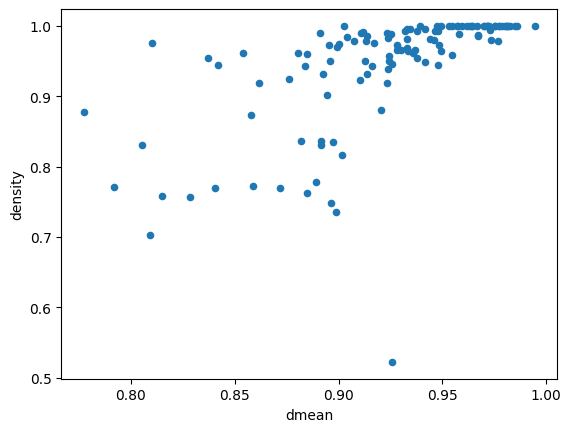

In [51]:
infos.plot.scatter(x='dmean', y='density')

In [52]:
def look4one_community(idx):
    row = communities_df.loc[idx]
    row_infos = infos.loc[idx] 
    print("\n\t------INFOS------")
    print(f"Mean: {row_infos.dmean} | Median: {row_infos.dmedian} | Density: {row_infos.density} | Community_size: {row.community_size}\n",
          f"| Quantile 25%: {row_infos.quantile_025} | Quantile 95%: {row_infos.quantile_095} | Quantile 5%: {row_infos.quantile_005}")
    print("    ------TF_IDF_TOP_WORDS------")
    print("    ", row.tf_idf_top_words)
    print("\n    ------COUNT_VECTORIZER_TOP_WORDS------")
    print("    ", row.count_vectorizer_top_words)
    
    print("\t------PRODUCTS_NAME_SAMPLE------")
    products_list = row.product_name_list[:25]
    for product in products_list:
        print(product)
    print("\t------CATEGORY_COUNTS------")
    print(row.category_counts, end="\n\n" + "-" * 150 + "\n")
    

In [89]:
look4one_community(031.0)


	------INFOS------
Mean: 0.9243509343384749 | Median: 0.937007191775288 | Density: 0.9574007220216606 | Community_size: 554
 | Quantile 25%: 0.8894329323910715 | Quantile 95%: 0.9947831908481081 | Quantile 5%: 0.8203076549753189
	------PRODUCTS_NAME_SAMPLE------
yaj canape lit gris clair velours yos7613814614924
yaj canapes canape lit a 2places avec_deux oreillers noir velours dx0681
betteve canape lit a 2places avec_deux oreillers gris fonce velours style7
yaj canape lit avec_accoudoirs noir tissu yaj351889
canape lit avec_porte gobelets jaune clair tissu dio7809686236375
yum canape lit avec_coussins gris clair tissu vbe7068512448980
canape lit en forme de l gris clair 255x140x70 cm tissu ean 7809686808206
yaj canape 2places avec_accoudoirs noir chrome et velours yaj282163
yaj jeu de canape a 2places et a 3places cuir synthetique blanc yaj272180
yaj canape lit avec_coussins gris clair velours yos7290578592585
canape lit gris fonce velours dio7809686232667
yaj canape lit avec_porte go

In [90]:
print(infos.columns)
infos.sort_values('density', inplace=True)
community_ids = infos[infos.quantile_005 > 0.945].index
print(f"Number of total community is: {len(community_ids)}")
for community_idx in community_ids:
    look4one_community(community_idx)

Index(['dmean', 'dmedian', 'quantile_025', 'quantile_095', 'quantile_005',
       'community_size', 'len_edges', 'density'],
      dtype='object')
Number of total community is: 18

	------INFOS------
Mean: 0.9768361197147838 | Median: 0.9811613599905056 | Density: 0.978 | Community_size: 100
 | Quantile 25%: 0.9785142439720755 | Quantile 95%: 0.987216169486747 | Quantile 5%: 0.972305090185542
	------PRODUCTS_NAME_SAMPLE------
housse de canape yescustom style 790x140 cm housse de canape extensible antiderapante universelle decoration d interieur
housse de canape yescustom style 18145x185 cm housse de canape extensible antiderapante universelle decoration d interieur
housse de canape yescustom style 2190x230 cm housse de canape extensible antiderapante universelle decoration d interieur
housse de canape yescustom style 6145x185 cm housse de canape extensible antiderapante universelle decoration d interieur
housse sofe canape universelle imprimee serviette canape antiderapante compris sty

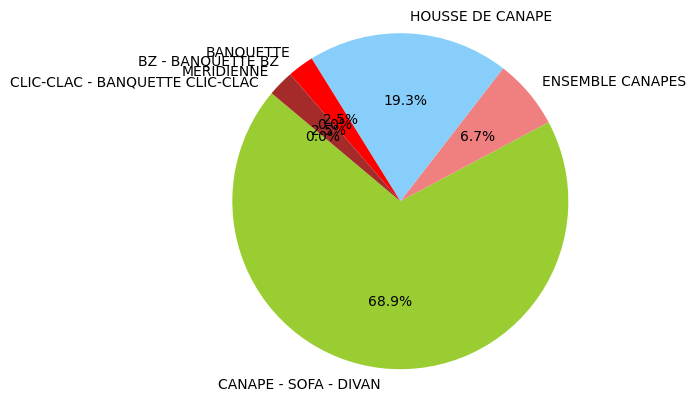

In [56]:
import matplotlib.pyplot as plt

major_categ_counts = {'CLIC-CLAC - BANQUETTE CLIC-CLAC': 0, 'CANAPE - SOFA - DIVAN': 0, 'ENSEMBLE CANAPES': 0, 'HOUSSE DE CANAPE': 0, 'BANQUETTE': 0, 'BZ - BANQUETTE BZ': 0, 'MERIDIENNE': 0}
for i, row in communities_df.iterrows():
    categ = row.category_counts
    major_categ_key = max(categ, key=categ.get)
    major_categ_counts[major_categ_key] += 1
    
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red', 'black', 'brown']
plt.pie(major_categ_counts.values(), labels=major_categ_counts.keys(), colors=colors, autopct='%1.1f%%', startangle=140)

plt.axis('equal')
plt.show()